# Chapter 9: Options

Options are powerful financial derivatives that provide the right, but not the obligation, to buy (call) or sell (put) an underlying asset at a predetermined price (strike price) by a specified date (expiration). They serve three primary purposes:

Speculation: Profit from price movements with limited risk

Hedging: Protect existing positions from adverse price movements

Income Generation: Earn premiums through option writing

Key Characteristics:

1. Call Option: Right to buy at strike price

2. Put Option: Right to sell at strike price

3. Strike Price (K): Predetermined transaction price

4. Expiration Date: When the option contract ends

5. Premium: Price paid for the option


In [1]:
# First, let's install and import necessary packages
import QuantLib as ql
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm

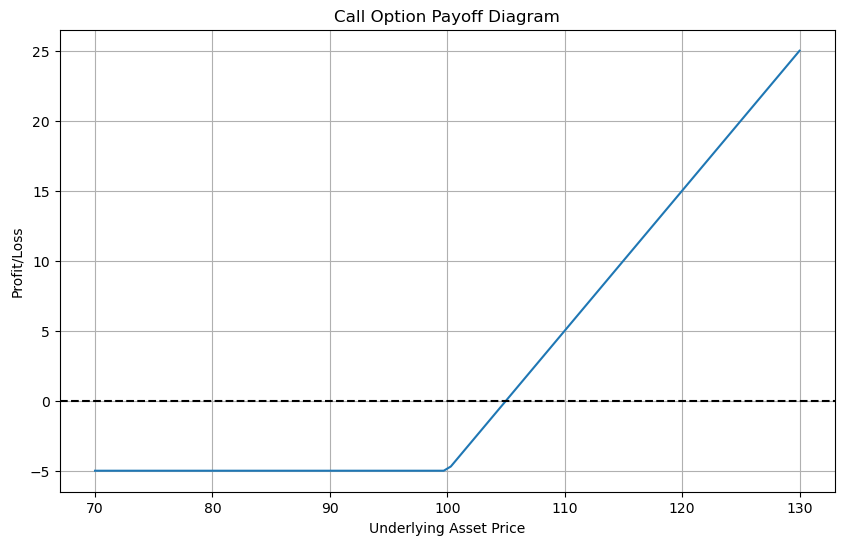

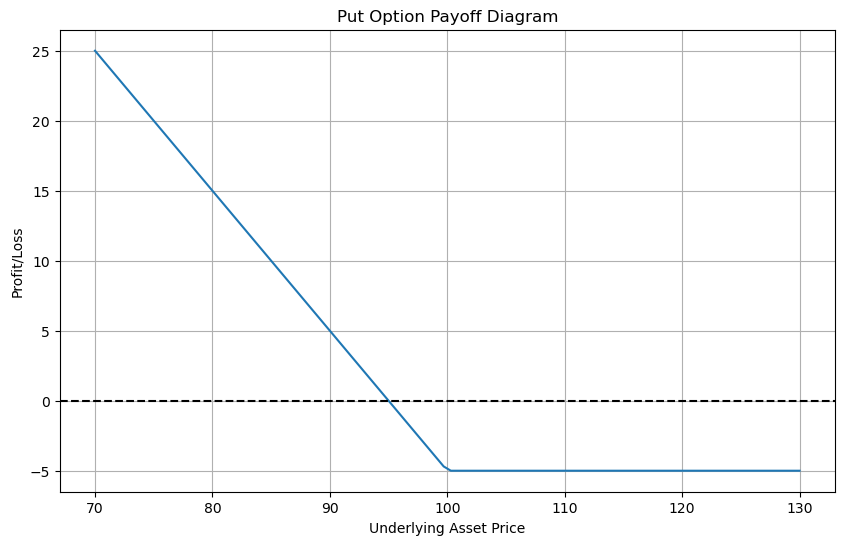

In [2]:
# Visualizing option payoffs
def plot_payoff(option_type='call', strike=100, premium=5):
    prices = np.linspace(70, 130, 100)
    if option_type == 'call':
        payoff = np.maximum(prices - strike, 0) - premium
    else:
        payoff = np.maximum(strike - prices, 0) - premium
    
    plt.figure(figsize=(10,6))
    plt.plot(prices, payoff)
    plt.axhline(0, color='k', linestyle='--')
    plt.title(f"{option_type.title()} Option Payoff Diagram")
    plt.xlabel("Underlying Asset Price")
    plt.ylabel("Profit/Loss")
    plt.grid(True)
    plt.show()

plot_payoff('call')
plot_payoff('put')

## 9.1 Option Valuation with Black-Scholes Model

The Black-Scholes model prices European options using:

S = Current stock price

K = Strike price

T = Time to expiration (years)

r = Risk-free rate

σ = Volatility

In [3]:
def black_scholes(S, K, T, r, sigma, option_type='call'):
    """
    Calculate Black-Scholes option price
    
    Parameters:
    S : float - Current stock price
    K : float - Strike price
    T : float - Time to expiration (in years)
    r : float - Risk-free rate
    sigma : float - Volatility
    option_type : str - 'call' or 'put'
    """
    d1 = (np.log(S/K) + (r + 0.5*sigma**2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    
    if option_type == 'call':
        price = S*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)
    else:
        price = K*np.exp(-r*T)*norm.cdf(-d2) - S*norm.cdf(-d1)
    
    return price

# Example calculation
call_price = black_scholes(100, 105, 1, 0.05, 0.2, 'call')
put_price = black_scholes(100, 95, 1, 0.05, 0.2, 'put')
print(f"Call Option Price: ${call_price:.2f}")
print(f"Put Option Price: ${put_price:.2f}")


Call Option Price: $8.02
Put Option Price: $3.71


Greeks: Measuring Option Sensitivity

In [4]:
def calculate_greeks(S, K, T, r, sigma, option_type='call'):
    d1 = (np.log(S/K) + (r + 0.5*sigma**2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    
    greeks = {}
    
    if option_type == 'call':
        greeks['delta'] = norm.cdf(d1)
        greeks['gamma'] = norm.pdf(d1)/(S*sigma*np.sqrt(T))
        greeks['theta'] = (-S*norm.pdf(d1)*sigma/(2*np.sqrt(T)) - r*K*np.exp(-r*T)*norm.cdf(d2))/365
        greeks['vega'] = S*norm.pdf(d1)*np.sqrt(T)/100
        greeks['rho'] = K*T*np.exp(-r*T)*norm.cdf(d2)/100
    else:
        greeks['delta'] = norm.cdf(d1) - 1
        greeks['gamma'] = norm.pdf(d1)/(S*sigma*np.sqrt(T))
        greeks['theta'] = (-S*norm.pdf(d1)*sigma/(2*np.sqrt(T)) + r*K*np.exp(-r*T)*norm.cdf(-d2))/365
        greeks['vega'] = S*norm.pdf(d1)*np.sqrt(T)/100
        greeks['rho'] = -K*T*np.exp(-r*T)*norm.cdf(-d2)/100
    
    return greeks

greeks = calculate_greeks(100, 100, 0.5, 0.05, 0.2, 'call')
print("Option Greeks:")
for greek, value in greeks.items():
    print(f"{greek.title()}: {value:.4f}")


Option Greeks:
Delta: 0.5977
Gamma: 0.0274
Theta: -0.0222
Vega: 0.2736
Rho: 0.2644


## 9.2 Option Strategies

1. Covered Call Strategy

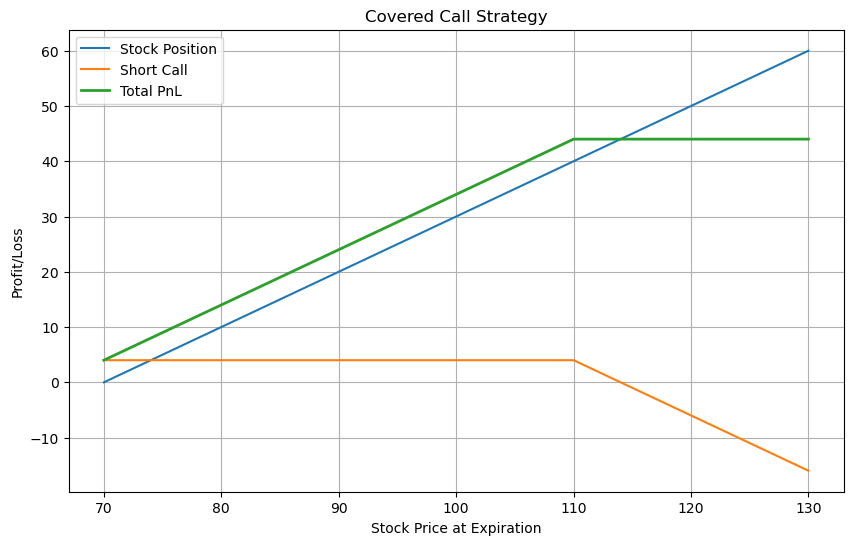

In [5]:
def covered_call(S_range, K, premium):
    stock_pnl = S_range - S_range[0]
    option_pnl = premium - np.maximum(S_range - K, 0)
    total_pnl = stock_pnl + option_pnl
    
    plt.figure(figsize=(10,6))
    plt.plot(S_range, stock_pnl, label='Stock Position')
    plt.plot(S_range, option_pnl, label='Short Call')
    plt.plot(S_range, total_pnl, label='Total PnL', linewidth=2)
    plt.title("Covered Call Strategy")
    plt.xlabel("Stock Price at Expiration")
    plt.ylabel("Profit/Loss")
    plt.legend()
    plt.grid()
    plt.show()

covered_call(np.linspace(70, 130, 100), 110, 4)


2. Protective Put Strategy

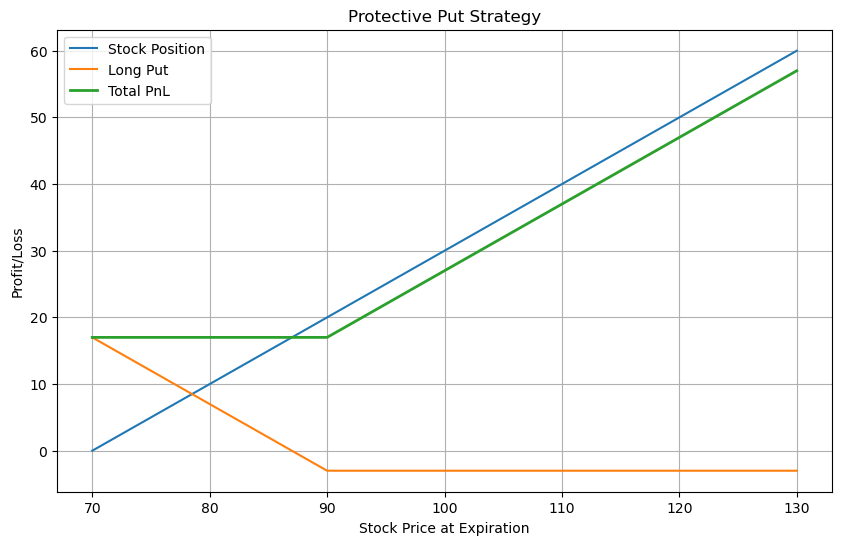

In [6]:
def protective_put(S_range, K, premium):
    stock_pnl = S_range - S_range[0]
    option_pnl = np.maximum(K - S_range, 0) - premium
    total_pnl = stock_pnl + option_pnl
    
    plt.figure(figsize=(10,6))
    plt.plot(S_range, stock_pnl, label='Stock Position')
    plt.plot(S_range, option_pnl, label='Long Put')
    plt.plot(S_range, total_pnl, label='Total PnL', linewidth=2)
    plt.title("Protective Put Strategy")
    plt.xlabel("Stock Price at Expiration")
    plt.ylabel("Profit/Loss")
    plt.legend()
    plt.grid()
    plt.show()

protective_put(np.linspace(70, 130, 100), 90, 3)

## 9.3 Straddle Strategy

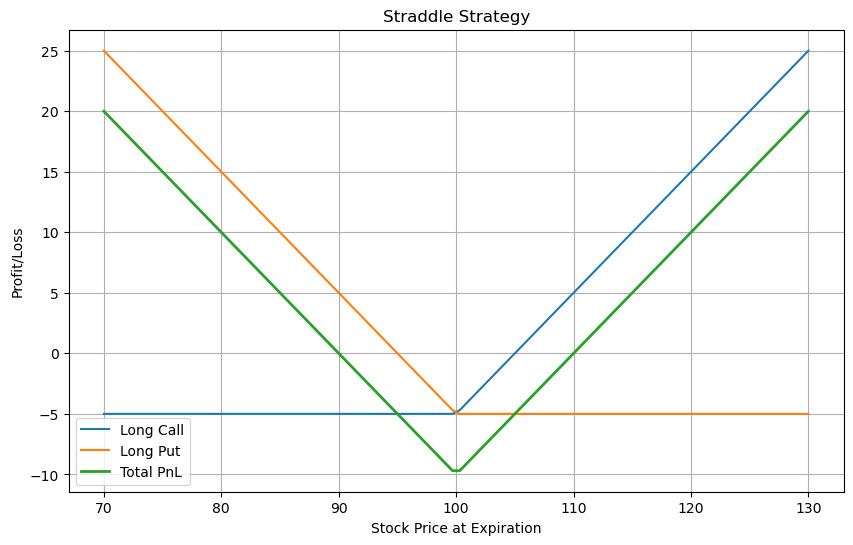

In [7]:
def straddle(S_range, K, call_premium, put_premium):
    call_pnl = np.maximum(S_range - K, 0) - call_premium
    put_pnl = np.maximum(K - S_range, 0) - put_premium
    total_pnl = call_pnl + put_pnl
    
    plt.figure(figsize=(10,6))
    plt.plot(S_range, call_pnl, label='Long Call')
    plt.plot(S_range, put_pnl, label='Long Put')
    plt.plot(S_range, total_pnl, label='Total PnL', linewidth=2)
    plt.title("Straddle Strategy")
    plt.xlabel("Stock Price at Expiration")
    plt.ylabel("Profit/Loss")
    plt.legend()
    plt.grid()
    plt.show()

straddle(np.linspace(70, 130, 100), 100, 5, 5)


## 9.4 Advanced Pricing with QuantLib

In [8]:
def quantlib_option_pricer(spot=100, strike=100, risk_free=0.05, 
                         volatility=0.2, dividend=0.0, 
                         expiry_date="2024-12-31", 
                         calculation_date="2024-06-01",
                         option_type="call"):
    """
    Parameters:
    spot (float): Current price of the underlying asset
    strike (float): Option strike price
    risk_free (float): Annualized risk-free rate (e.g., 0.05 for 5%)
    volatility (float): Annualized volatility (e.g., 0.2 for 20%)
    dividend (float): Continuous dividend yield
    expiry_date (str): Option expiration date in 'YYYY-MM-DD' format
    calculation_date (str): Valuation date in 'YYYY-MM-DD' format
    option_type (str): 'call' or 'put'
    
    Returns:
    dict: Dictionary containing price and all major Greeks
    """
    
    # 1. DATE SETUP
    # Convert string dates to QuantLib date objects
    # QuantLib uses day-month-year convention internally
    maturity = ql.DateParser.parseFormatted(expiry_date, "%Y-%m-%d")
    calc_date = ql.DateParser.parseFormatted(calculation_date, "%Y-%m-%d")
    
    # Set the global evaluation date for all calculations
    ql.Settings.instance().evaluationDate = calc_date
    
    # 2. OPTION TYPE SETUP
    # Create the option payoff specification
    option_type = ql.Option.Call if option_type == "call" else ql.Option.Put
    payoff = ql.PlainVanillaPayoff(option_type, strike)
    
    # European exercise (exercise only at expiration)
    exercise = ql.EuropeanExercise(maturity)
    
    # Combine payoff and exercise into option object
    option = ql.VanillaOption(payoff, exercise)
    
    # 3. MARKET DATA SETUP
    # Day count convention (how to calculate time periods)
    day_count = ql.Actual365Fixed()
    
    # Calendar for business days (NullCalendar ignores holidays)
    calendar = ql.NullCalendar()
    
    # Create handles for market data:
    # - spot_handle: Current price of underlying
    # - flat_ts: Risk-free rate term structure
    # - dividend_ts: Dividend yield term structure
    # - vol_handle: Volatility structure
    
    spot_handle = ql.QuoteHandle(ql.SimpleQuote(spot))
    flat_ts = ql.YieldTermStructureHandle(
        ql.FlatForward(calc_date, risk_free, day_count))
    dividend_ts = ql.YieldTermStructureHandle(
        ql.FlatForward(calc_date, dividend, day_count))
    vol_handle = ql.BlackVolTermStructureHandle(
        ql.BlackConstantVol(calc_date, calendar, volatility, day_count))
    
    # 4. PRICING PROCESS
    # Create the Black-Scholes-Merton process (extends BS with dividends)
    bsm_process = ql.BlackScholesMertonProcess(spot_handle, 
                                            dividend_ts, 
                                            flat_ts, 
                                            vol_handle)
    
    # Set up the analytical pricing engine for European options
    option.setPricingEngine(ql.AnalyticEuropeanEngine(bsm_process))
    
    # 5. RESULTS COLLECTION
    # Return all metrics in a dictionary
    return {
        "price": option.NPV(),          # Net Present Value (option price)
        "delta": option.delta(),        # Price sensitivity to underlying
        "gamma": option.gamma(),        # Delta's sensitivity to price
        "theta": option.thetaPerDay(),  # Time decay (per calendar day)
        "vega": option.vega()/100,     # Sensitivity to 1% vol change
        "rho": option.rho()/100        # Sensitivity to 1% rate change
    }

# Example usage with detailed explanation
result = quantlib_option_pricer(
    spot=105,              # Current stock price = $105
    strike=100,            # Strike price = $100
    risk_free=0.05,        # 5% risk-free rate
    volatility=0.25,       # 25% annualized volatility
    dividend=0.02,         # 2% continuous dividend yield
    expiry_date="2024-12-31",  # Expires Dec 31, 2024
    calculation_date="2024-06-01",  # Pricing as of June 1, 2024
    option_type="call"     # Pricing a call option
)

print("QuantLib Pricing Results:")
for metric, value in result.items():
    print(f"{metric.upper():<8}: {value:.6f}")


QuantLib Pricing Results:
PRICE   : 11.424762
DELTA   : 0.663199
GAMMA   : 0.017829
THETA   : -0.020988
VEGA    : 0.286767
RHO     : 0.339698


##  9.5 Summary 

This chapter provides a comprehensive exploration of options as versatile financial instruments that grant holders the right, but not the obligation, to buy or sell underlying assets at predetermined prices. At its core, the material distinguishes between call options, which profit when asset prices rise above strike levels, and put options, which gain value when prices fall below strike points. The discussion emphasizes three primary uses of options: speculative positioning for leveraged returns, protective hedging against adverse market moves, and income generation through premium collection strategies.

The chapter thoroughly examines the Black-Scholes model as the foundational framework for pricing European options, detailing how it incorporates current asset prices, strike levels, time remaining until expiration, risk-free interest rates, and market volatility. Through practical Python implementations, readers learn to calculate not just option prices but also the sensitivity measures known as the Greeks - including Delta for price exposure, Gamma for curvature risk, Theta for time decay, Vega for volatility sensitivity, and Rho for interest rate effects.

Several common trading strategies receive detailed treatment, particularly the covered call approach that generates income while capping upside potential, protective puts that insure against downside risk, and straddles that profit from significant price movements in either direction. Each strategy is illustrated with clear payoff diagrams generated through Python's visualization tools.

The latter sections introduce professional-grade pricing techniques using QuantLib, demonstrating how to incorporate real-world complexities like dividend yields and precise expiration timelines. This advanced treatment bridges the gap between theoretical models and practical implementation, showing how institutional investors approach options valuation.